# Modele de réseau neuronale

Toutes les étapes pour arriver à un modele correct

## Imports

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
#import seaborn as sns #On ne sait jamais que ça serve
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler #Normalisation
import random

### Paramètres généraux

In [2]:
nb_classes = 13 #Nombre de classes

## Fonctions d'imports et preprocess

#### Import

In [3]:
def get_mov_imgs_from_path(path,fps = -1,color = 'gray'):
    '''
    Retourne une liste d'images pour une vidéo. La liste d'image a le nombre de fps voulu
    reprend que le mouvement
    '''
    
    cap = cv2.VideoCapture(path)
    fps_actu = cap.get(cv2.CAP_PROP_FPS)
    print(f"Traitement de la video n° {path}       ",end="\r")
    if fps <= -1: fps = fps_actu #Je peux ne pas donner de fps et ça va prendre le nombre d'fps initial
    ecart_voulu = int(1000/fps)
    ecart_initial = int(1000/fps_actu)
    imgs = []
    
    ret, frame = cap.read()
    
    while(cap.isOpened()):
        prev = frame
        ret, frame = cap.read()

        if ret: #Sinon ça plante quand il n'y a plus d'images
            #Récupère seulement certaines images
            t_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
            modulo = t_ms % ecart_voulu
            if modulo < ecart_initial:
                #Isoler les images
                
                diff = cv2.absdiff(frame,prev)  
                if color == 'gray':
                    diff_gray = cv2.cvtColor(diff,cv2.COLOR_BGR2GRAY)
                elif color == 'rgb':
                    diff_gray = diff

                    
                #Première normalisation (elle n'est peut-être pas obligatoire)
                max_ = np.max(diff_gray)
                if max_ == 0:
                    max_ = 1
                ratio = 255.0 / max_
                diff_gray = diff_gray * ratio
                
                
                #On va travailler avec des images en nuance de gris, c'est bcp plus simple
                imgs.append(diff_gray)
            
        else: #Va jusqu'au bout de la vidéo
            break
    else:
        print("Le fichier n'a pas pu être ouvert")
    cap.release()
    
    return imgs

#### Resize

In [4]:
def resize_imgs(imgs,nsize):
    '''
    Change la taille de l'image.
    Le premier élément de nsize est la longueur (width), le deuxième la hauteur (height)
    '''
    return [cv2.resize(img, dsize=nsize, interpolation=cv2.INTER_CUBIC) for img in imgs]

#### Normalisation

In [5]:
def scale_by_pixels(img, x_min, x_max):
    '''
    Scale une image entre 0 et 1.
    Méthode pas efficace mais fonctionnelle contrairement à d'autres méthodes 
    qui faisaient lignes par lignes ce qui causait des erreurs 
    dans le résultat (lignes dans l'image)
    '''
    new_img = img.copy()
    p_min = 1000
    p_max = -1000
    for line in img:
        for pixel in line:
            p_min = min(p_min,pixel)
            p_max = max(p_max,pixel)
    
    #p_min et p_max sont les min et max totaux de mon image
    for l, line in enumerate(img):
        for p,pixel in enumerate(line):
            nom = (pixel - p_min)*(x_max - x_min)
            denom = (p_max - p_min)
            if denom == 0: denom = 1
            new_img[l][p] = x_min + nom/denom
    return new_img

In [6]:
def normalize_imgs(imgs):
    '''
    Normalise une série d'images
    '''
    norm_imgs = []
    for img in imgs:
        norm_img = scale_by_pixels(img,0,1)
        norm_imgs.append(norm_img)
#     print(f"Après normalisation, max = {np.max(norm_imgs)} et min = {np.min(norm_imgs)}")
    return norm_imgs

## Fonction de générateur

In [26]:
def my_gen(labels_list, folder_path, batch_size = 10, pointer = 0, fps = 5, size = (160,120)):
    '''
    à partir de la liste des labels et de la position du foler
    Retourne:
    -une liste d'images de vidéos de shape (batch_size,n_frames,height,width[,channels])
        n_frames = fps*2.4
    -Une liste de numérique avec les labels correspondant aux images (de len = batch_size)
    -Un pointer qui permet de faire tourner my_gen à nouveau et recevoir les éléments suivants de la liste
    
    
    Normalement on peut envoyer X et y_num dans le modele directement (avec fit ou train_on_batch, les deux devraient fonctionner)
    Je vais essayer de travailler avec des thread pour avoir un thread en Train et un trhead en gen
    '''
    
    y_num = []
    X = []
    for i in range(pointer, batch_size + pointer):
        pointer = i+1
        if i >= len(labels_list):
            break
        label, video_name = labels_list[i]
        
        #Label en numérique
        y_num.append(labels_n[label])
        
        #Preprocess d'images
        file_path = folder_path + "\\" + video_name
        imgs_of_video = get_mov_imgs_from_path(file_path,fps,'gray') #Gray ou rgb
        resized_imgs = resize_imgs(imgs_of_video, size)
        norm_imgs = normalize_imgs(resized_imgs)
        
        X.append(norm_imgs)
        
    
    X = np.array(X)
    y = np.array(y_num)
    
    #Ajouter une dimsension en à la fin est nécessaire pour certains modèle
    #Commenter cette ligne si ce n'est pas nécessaire
    X = np.expand_dims(X, axis=len(X.shape)) 
    
    # Si le modele est compile avec :loss='sparse_categorical_crossentropy'
    # Il faut un y catégorique , faire ça hors de la fonction
    #y = to_categorical(y, num_classes = nb_classes)

    return (X, y, pointer)

## Fabrication des modeles

#### Imports

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import  Dense, Conv3D, BatchNormalization,MaxPooling3D, Dropout, LSTM
from tensorflow.keras.utils import to_categorical




In [9]:
#Voir Model_experiences.ipynb pour les différents modeles

In [10]:
#creation du modele

In [11]:
#compilation

##### Chargement d'un modele préentrainé (par nous même)

In [12]:
model_stolen_saved = keras.models.load_model('Saved_model\\modele_stolen_compile')

## Generator

In [13]:
def homemade_fit_generator(model, labels_val,batch_size,epochs,fps = 5,size = (160,120)):
    '''
    Charge les données à partir du csv labels_val et train le model avec
    les différents paramètres
    Le model est train.
    
    Si besoin, return de X,y et model (mais normalement le model original est train)
    '''
    
    
    pointer = 0
    can_continue = True

    while can_continue:
        X, y_num, pointer = my_gen(labels_val, "DATA\\Videos",batch_size = batch_size,fps = fps, size = size, pointer = pointer)
        
        #Catégorisation pour train
        y = to_categorical(y_num, num_classes = nb_classes)
        
        if pointer >= len(labels_val):
            can_continue = False
        print()

        #print('vidéos chargées, shape:',X.shape,'. y len : ',len(y_num)) #DEBUG
       
        model.fit(X, y,
                batch_size = 10,
                epochs=2,
                verbose=1,
                validation_split=0.2)
    return model, X, y

## Import des données et traitement

In [14]:
#Import des labels
labels_csv = pd.read_csv("DATA\\labels.csv")
labels_name = pd.read_csv("DATA\\labels_list.csv")
labels_tests_csv = pd.read_csv("DATA\\labels_tests.csv")

In [15]:
#Melange la liste
labels = list(labels_csv.values)
random.shuffle(labels) #Il faut absolument shuffle pour train

labels_tests = list(labels_tests_csv.values) #Il ne faut pas shuffle pour test

#Créé un dictionnaire qui associe le nom du label et un numérique afin de le mettre dans le modele
labels_n = {}
for i,label in enumerate(labels_name.values):
    labels_n[label[0]] = i
    labels_n[i] = label[0]

## Train

In [16]:
#Parametres du generator
batch_size = 50
fps = 5 #Pour une shape de 12 (à définir avant de faire le modele)
size = (160,120)

In [17]:
#homemade_fit_generator(model_stolen_saved, labels, batch_size = batch_size, epochs = 3, fps = fps, size = size)

## Tests

In [27]:
X_test, y_test, _ = my_gen(labels_tests, "DATA\\V_tests",batch_size = 1000,fps = fps, size = size)
#Grand batch_size afin de prendre toutes les données

In [28]:
y_pred = model_stolen_saved.predict(X_test)

### visualisation des  résultats

In [30]:
import fidle.pwk as pwk

C:\Users\william\Documents\Scolaire\M1\Systèmes_Intelligents\Hand_Gesture_Recognition\fidle\pwk.py:520: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


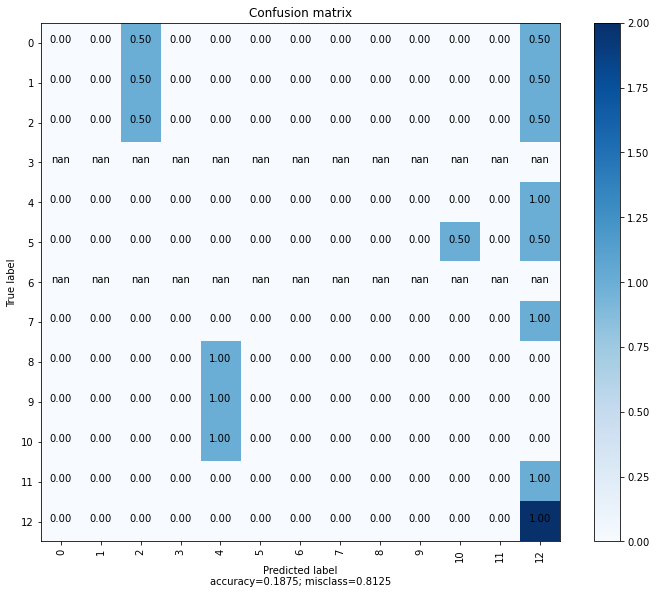

In [31]:
y_pred_arg = np.argmax(y_pred, axis=-1)
pwk.plot_confusion_matrix(y_test,y_pred_arg,range(nb_classes),normalize=True)